Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### *Continue using 5-fold cross validation on the training dataset. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.*



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [ ]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed, split_dataset, preprocess_dataset, initialise_loaders

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [ ]:
from common_utils import MLP_adjustable_depth, CustomDataset, loss_fn

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/a - csv file/simplified.csv')

In [ ]:
df['label'] = df['filename'].str.split('_').str[-2]

columns_to_drop = ['filename', 'label']
test_size = 0.2
random_state = 42

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size, random_state)

In [ ]:
def train(model, optimizer, num_epochs, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_dataloader, test_dataloader = initialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)

    # initialise train accuracies and losses
    train_accuracies = 0.0
    train_losses = 0.0

    # for loop for each epoch
    for epoch in range(num_epochs):
        # set start time
        start_time = time.time()

        # initialise correct predictions and total losses of each batch
        correct_train_predictions = 0
        total_losses = 0.0

        # for loop for each batch
        for batch_index, (X_train_batch, y_train_batch) in enumerate(train_dataloader):
            # train mode
            model.train()

            optimizer.zero_grad()
            y_train_predicted = model(X_train_batch)

            # calculate correct predictions and total losses of each batch
            loss = loss_fn(y_train_predicted, y_train_batch.unsqueeze(1).float())
            y_train_predicted_labels = (y_train_predicted >= 0.5).float()
            correct_train_predictions += (y_train_predicted_labels == y_train_batch.unsqueeze(1)).sum().item()
            total_losses += loss.item()

            loss.backward()
            optimizer.step()

        # calculate train accuracies and losses
        train_accuracies = correct_train_predictions / len(train_dataloader.dataset)
        train_losses = total_losses / len(train_dataloader.dataset)

        # set end time
        end_time = time.time()
        # calculate times taken to run final epoch
        times = end_time - start_time

        # evaluation mode
        model.eval()

        # initialise test accuracies and losses
        test_accuracies = 0.0
        test_losses = 0.0

        with torch.no_grad():
            # initialise correct predictions and losses for each batch
            correct_test_predictions = 0
            total_test_losses = 0.0

            # for loop for each batch
            for batch_index, (X_test_batch, y_test_batch) in enumerate(test_dataloader):

                # calculate correct predictions and losses for each batch
                y_test_predicted = model(X_test_batch)
                loss = loss_fn(y_test_predicted, y_test_batch.unsqueeze(1).float())
                y_test_predicted_labels = (y_test_predicted >= 0.5).float()
                correct_test_predictions += (y_test_predicted_labels == y_test_batch.unsqueeze(1)).sum().item()
                total_test_losses += loss.item()

            # calculate test accuracies and losses
            test_accuracies = correct_test_predictions / len(test_dataloader.dataset)
            test_losses = total_test_losses / len(test_dataloader.dataset)


    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [ ]:
def find_optimal_hyperparameter(X_train, y_train, parameters, batch_size):
    # number of fold
    k = 5
    # list of number of the hidden layers
    num_hidden = [1, 2, 3]
    # initialize cross validation accuracies and times
    cross_validation_accuracies = {}
    cross_validation_times = {}

    # for loop for each number of hidden layers
    for hidden_layers in num_hidden:

        # for loop for each number of hidden neurons
        for neurons in tqdm.tqdm(parameters, desc = f"Number of hidden layers: {hidden_layers}"):

            # set hyperparameter (except from number of hidden neurons)
            model = MLP_adjustable_depth(no_layers = hidden_layers, no_features = X_train.shape[1], no_hidden = neurons, no_labels = 1)
            optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
            num_epochs = 100
            batch_size = 512

            # use kfold cross validation
            kf = KFold(n_splits = k, shuffle = True, random_state = 42)
            fold = 1

            # create a new key in the cross_validation_accuracies/times
            cross_validation_accuracies[f"Hidden Layers: {hidden_layers}, Neurons: {neurons}"] = []
            cross_validation_times[f"Hidden Layers: {hidden_layers}, Neurons: {neurons}"] = []

            # for loop for each fold (kfold cross validation)
            for train_index, val_index in kf.split(X_train):
                X_train_splited, X_val_splited = X_train[train_index], X_train[val_index]
                y_train_splited, y_val_splited = y_train[train_index], y_train[val_index]

                # preprocess the X train and val dataset
                X_train_splited_scaled, X_val_splited_scaled = preprocess_dataset(X_train_splited, X_val_splited)
                # find train/test accuracies and losses & times taken for training
                train_accuracies, train_losses,test_accuracies, test_losses, times = train(model, optimizer, num_epochs,
                                                                                            X_train_splited_scaled, y_train_splited,
                                                                                            X_val_splited_scaled, y_val_splited,
                                                                                            batch_size)
                # append new value to the cross_validation_accuracies and cross_validation_times dictionaries
                cross_validation_accuracies[f"Hidden Layers: {hidden_layers}, Neurons: {neurons}"].append(test_accuracies)
                cross_validation_times[f"Hidden Layers: {hidden_layers}, Neurons: {neurons}"].append(times)

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''

num_neurons = [64, 128, 256]
optimal_bs = 512
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, num_neurons, optimal_bs)

Hidden layers: 3: 100%|██████████| 3/3 [08:51<00:00, 177.22s/it]


In [ ]:
formatted_cv_accuracies_dict = {key: [round(val, 3) for val in value] for key, value in cross_validation_accuracies.items()}

for key, value in formatted_dict.items():
    print(f"{key}:")  # Print the key followed by a colon
    print(value)      # Print the value on a new line
    print()           # Add an extra blank line for separation

Hidden Layers: 1, Neurons: 64:
[0.722, 0.75, 0.8, 0.801, 0.814]

Hidden Layers: 1, Neurons: 128:
[0.735, 0.793, 0.844, 0.853, 0.86]

Hidden Layers: 1, Neurons: 256:
[0.749, 0.796, 0.853, 0.87, 0.893]

Hidden Layers: 2, Neurons: 64:
[0.753, 0.824, 0.87, 0.876, 0.898]

Hidden Layers: 2, Neurons: 128:
[0.773, 0.874, 0.92, 0.947, 0.956]

Hidden Layers: 2, Neurons: 256:
[0.789, 0.911, 0.964, 0.977, 0.988]

Hidden Layers: 3, Neurons: 64:
[0.75, 0.811, 0.871, 0.852, 0.877]

Hidden Layers: 3, Neurons: 128:
[0.786, 0.88, 0.928, 0.939, 0.963]

Hidden Layers: 3, Neurons: 256:
[0.808, 0.925, 0.968, 0.979, 0.991]



In [ ]:
cross_validation_times

{'Hidden Layers: 1, Neurons: 64': [0.14682340621948242,
  0.14713573455810547,
  0.161116361618042,
  0.2392592430114746,
  0.1617450714111328],
 'Hidden Layers: 1, Neurons: 128': [0.23069143295288086,
  0.5318887233734131,
  0.16171574592590332,
  0.15412616729736328,
  0.16510295867919922],
 'Hidden Layers: 1, Neurons: 256': [0.1709425449371338,
  0.1824965476989746,
  0.2511887550354004,
  0.1863560676574707,
  0.1692812442779541],
 'Hidden Layers: 2, Neurons: 64': [0.2009446620941162,
  0.17449116706848145,
  0.19997644424438477,
  0.16738653182983398,
  0.16741013526916504],
 'Hidden Layers: 2, Neurons: 128': [0.21957683563232422,
  0.21204400062561035,
  0.20494389533996582,
  0.28540492057800293,
  0.19465112686157227],
 'Hidden Layers: 2, Neurons: 256': [0.29667186737060547,
  0.28910112380981445,
  0.28475356101989746,
  0.4055016040802002,
  0.2743654251098633],
 'Hidden Layers: 3, Neurons: 64': [0.21604037284851074,
  0.19413542747497559,
  0.19789528846740723,
  0.203271150

4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot.

In [ ]:
mean_cross_validation_accuracies = []
for key, value in cross_validation_accuracies.items():
    mean_cross_validation_accuracies.append(np.mean(value))

mean_cross_validation_accuracies = np.array(mean_cross_validation_accuracies)
print(mean_cross_validation_accuracies)

[0.77739762 0.81689995 0.83214101 0.84406428 0.89393468 0.92566096
 0.83214101 0.8992224  0.93416278]


In [ ]:
num_hidden = [1,2,3]
num_neurons = [64,128,256]
depth_n_width = []
for i in num_hidden:
    for j in num_neurons:
        depth_n_width.append(f"Hidden Layers: {i}\nNeurons: {j}")

print(depth_n_width)

['Hidden Layers: 1\nNeurons: 64', 'Hidden Layers: 1\nNeurons: 128', 'Hidden Layers: 1\nNeurons: 256', 'Hidden Layers: 2\nNeurons: 64', 'Hidden Layers: 2\nNeurons: 128', 'Hidden Layers: 2\nNeurons: 256', 'Hidden Layers: 3\nNeurons: 64', 'Hidden Layers: 3\nNeurons: 128', 'Hidden Layers: 3\nNeurons: 256']


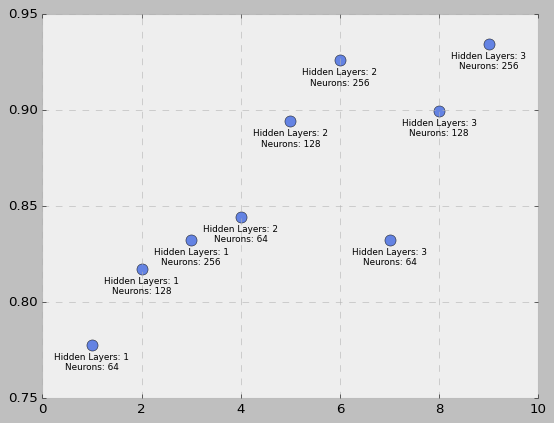

In [ ]:
x = [1,2,3,4,5,6,7,8,9]
y = mean_cross_validation_accuracies
labels = depth_n_width

# apply built-in style
plt.style.use("bmh")

# Create figure and set style
plt.figure(figsize=(8, 6))  # Set figure size and background color

# Create scatter plot with customized style
plt.scatter(x, y, color="royalblue", edgecolors="black", s=100, marker="o", alpha=0.8)  # Customize color, size, and transparency

# Add labels under each point
for i, label in enumerate(labels):
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0, -22), ha="center", fontsize = 8, color="black")

5. Select the optimal combination for the depth and width. State the rationale for your selection.

In [ ]:
optimal_combination = []
reason = " "
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

7. As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?